In [7]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.options.mode.chained_assignment = None  # default='warn'

# Input data files are available in the read-only "../data/" directory

import os
import os.path as osp

ds_name = 'original_data'
ds_folder = f'../data/{ds_name}'
for dirname, _, filenames in os.walk(ds_folder):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../data/original_data\edges.csv
../data/original_data\err_nodes.csv
../data/original_data\new_cluster_dynamics.csv


In [8]:
import seaborn as sns
import scipy.stats as stats
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import skew, norm
from sklearn.neighbors import KNeighborsRegressor
%matplotlib inline

In [9]:
#Import the files
node_df = pd.read_csv(f'{ds_folder}/new_cluster_dynamics.csv')
edge_df = pd.read_csv(f'{ds_folder}/edges.csv')

D:\Downloads\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [10]:
print('Shape of node data is', node_df.shape)
print ('Shape of edge data is', edge_df.shape)

Shape of node data is (13733047, 19)
Shape of edge data is (13712613, 5)


In [11]:
edge_df.tail()

,from,to,weight1,weight2,sim
13712608,1396,231,12,0.009602,999
13712609,1396,575,12,0.009680,999
13712610,1393,1397,3,0.002858,999
13712611,1397,42,1,0.000948,999
13712612,1397,607,17,0.015876,999


In [12]:
edge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13712613 entries, 0 to 13712612
Data columns (total 5 columns):
 #   Column   Dtype  
---  ------   -----  
 0   from     int64  
 1   to       int64  
 2   weight1  int64  
 3   weight2  float64
 4   sim      int64  
dtypes: float64(1), int64(4)
memory usage: 523.1 MB


In [13]:
#drop non-node data points
drop_node = np.where(pd.isna(node_df['node'])==True)
node_df = node_df.drop(drop_node[0])
print('Number of dropped node is', len(drop_node[0]))

node_df['sim'] = pd.to_numeric(node_df['sim'])
node_df['dynamic_model'] = pd.to_numeric(node_df['dynamic_model'])

Number of dropped node is 12038


### Count number of trees

In [14]:
node_tree_ids = node_df['sim'].unique()
edge_tree_ids = edge_df['sim'].unique()
#assert len(node_tree_ids) == len(edge_tree_ids), f'Node: {len(node_tree_ids)}, {len(edge_tree_ids)}'

num_trees = len(node_tree_ids)
tree_ids = node_tree_ids
print(f'Number of trees: {num_trees}')

Number of trees: 9685


### Error check duplicate number of nodes and edges on a tree
Number of nodes for one tree should equal to number of edges plus 1. 

In [15]:
err_dic = {}
err_treeids = []
for one_tree_id in node_tree_ids:
    onetree_node_df = node_df[node_df['sim'] == one_tree_id] 
    uni_node_sample = onetree_node_df.drop_duplicates()
    uni_node = onetree_node_df.drop_duplicates('node')
    onetree_edge_df = edge_df[edge_df['sim'] == one_tree_id]
    uni_edge_sample = onetree_edge_df.drop_duplicates()
    uni_edge = onetree_edge_df.drop_duplicates(['from','to'])
    if len(uni_node) == len(uni_edge)+1:
        continue
    else:
        err_dic[one_tree_id] = [len(onetree_node_df),len(uni_node_sample),len(uni_node),len(onetree_edge_df),len(uni_edge_sample),len(uni_edge)]
        err_treeids.append(one_tree_id)
        node_df = node_df.drop(node_df[node_df['sim']==one_tree_id].index)
        edge_df = edge_df.drop(edge_df[edge_df['sim']==one_tree_id].index)


In [16]:
print('The id of error tree:')
print(err_treeids)

The id of error tree:
[]


In [17]:
err_df = pd.DataFrame.from_dict(err_dic, orient='index', 
                                columns=["#raw_nodes", 
                                         "#unique_nodes_consider_feats", "#unique_nodes_no_consider_feats", 
                                         "#raw_edges", "#unique_edges_consider_feats", "#unique_edges_no_consider_feats"])
err_df.index.name = "sim"
err_df

,#raw_nodes,#unique_nodes_consider_feats,#unique_nodes_no_consider_feats,#raw_edges,#unique_edges_consider_feats,#unique_edges_no_consider_feats
sim,,,,,,


In [18]:
err_df.to_csv(f"{ds_folder}/duplicate_trees.csv")

In [19]:
for id in edge_tree_ids:
    if id in node_tree_ids:
        continue
    else:
        print(id)

2


In [20]:
edge_df[edge_df['sim']==2]

,from,to,weight1,weight2,sim
8327565,668,669,6,0.005062,2
8327566,669,670,11,0.009525,2
8327567,670,671,5,0.004300,2
8327568,671,672,3,0.002828,2
8327569,672,673,5,0.004389,2
...,...,...,...,...,...
8328849,1289,571,11,0.010801,2
8328850,1289,585,11,0.010517,2
8328851,1286,1290,19,0.018272,2
8328852,1290,86,10,0.008464,2


In [21]:
edge_df = edge_df.drop(edge_df[edge_df['sim']==2].index)

In [22]:
node_tree_ids = node_df['sim'].unique()
edge_tree_ids = edge_df['sim'].unique()
assert len(node_tree_ids) == len(edge_tree_ids), f'Node: {len(node_tree_ids)}, {len(edge_tree_ids)}'

num_trees = len(node_tree_ids)
tree_ids = node_tree_ids
print(f'Number of trees: {num_trees}')

Number of trees: 9685


In [23]:
print('Shape of node data is', node_df.shape)
print('Shape of edge data is', edge_df.shape)

Shape of node data is (13721009, 19)
Shape of edge data is (13711324, 5)


### Analysis the edge weights

In [24]:
aly_edge_feat_cols = ['weight1', 'weight2']
aly_edge_df = edge_df[aly_edge_feat_cols]

In [25]:
aly_edge_df.describe()

,weight1,weight2
count,1.371132e+07,1.371132e+07
mean,1.158920e+01,1.043065e-02
std,9.449977e+00,8.549155e-03
min,0.000000e+00,0.000000e+00
25%,4.000000e+00,3.749864e-03
50%,9.000000e+00,8.192930e-03
75%,1.700000e+01,1.509248e-02
max,1.060000e+02,8.970773e-02


array([[<AxesSubplot:title={'center':'weight1'}>,
        <AxesSubplot:title={'center':'weight2'}>]], dtype=object)

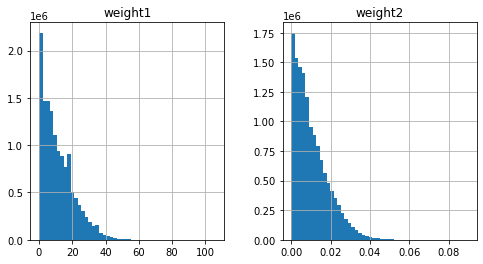

In [26]:
aly_edge_df.hist(bins=50,figsize=(8,4))

In [27]:
# Compute pairwise correlation of columns (pearson R: standard correlation coefficient)
aly_edge_df.corr()

,weight1,weight2
weight1,1.000000,0.994886
weight2,0.994886,1.000000


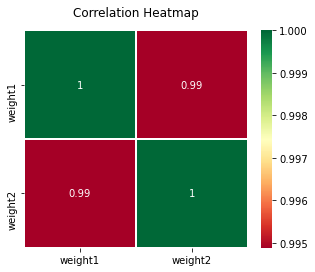

In [28]:
# Pearson Correlation Matrix

# Increase the size of the heatmap.
plt.figure(figsize=(5, 4))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(aly_edge_df.corr(), annot=True, linewidths=.5, cmap="RdYlGn")
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', pad=14);

### Get the node and edge distribution of the trees

In [29]:
node_tree_ids = node_df['sim'].unique()
edge_tree_ids = edge_df['sim'].unique()
assert len(node_tree_ids) == len(edge_tree_ids), f'Node: {len(node_tree_ids)}, {len(edge_tree_ids)}'

num_trees = len(node_tree_ids)
tree_ids = node_tree_ids
print(f'Number of trees: {num_trees}')

Number of trees: 9685


In [30]:
from collections import defaultdict

tree_dist_dict = defaultdict(list)

for tree_id in tree_ids:
    tree_dist_dict['sim'].append(tree_id)
    onetree_node_df = node_df[node_df['sim'] == tree_id] 
    num_nodes = onetree_node_df.shape[0]
    tree_dist_dict['num_nodes'].append(num_nodes)
    
    #num_background_nodes = onetree_node_df[onetree_node_df['cluster_id']=='Background'].shape[0]
    #tree_dist_dict['num_background_nodes'].append(num_background_nodes)
    #tree_dist_dict[f'rat_background_nodes'].append(num_background_nodes / num_nodes)
    
    for label in ['static', 'growth', 'decay']:
        num_label_nodes = onetree_node_df[onetree_node_df['dynamic']==label].shape[0]
        tree_dist_dict[f'num_{label}_nodes'].append(num_label_nodes)
        tree_dist_dict[f'rat_{label}_nodes'].append(num_label_nodes / num_nodes)
        
    onetree_edge_df = edge_df[edge_df['sim'] == tree_id]
    # print(onetree_edge_df.shape)
    tree_dist_dict['num_edges'].append(onetree_edge_df.shape[0])
    
tree_dist_df = pd.DataFrame.from_dict(tree_dist_dict)

array([[<AxesSubplot:title={'center':'sim'}>,
        <AxesSubplot:title={'center':'num_nodes'}>,
        <AxesSubplot:title={'center':'num_static_nodes'}>],
       [<AxesSubplot:title={'center':'rat_static_nodes'}>,
        <AxesSubplot:title={'center':'num_growth_nodes'}>,
        <AxesSubplot:title={'center':'rat_growth_nodes'}>],
       [<AxesSubplot:title={'center':'num_decay_nodes'}>,
        <AxesSubplot:title={'center':'rat_decay_nodes'}>,
        <AxesSubplot:title={'center':'num_edges'}>]], dtype=object)

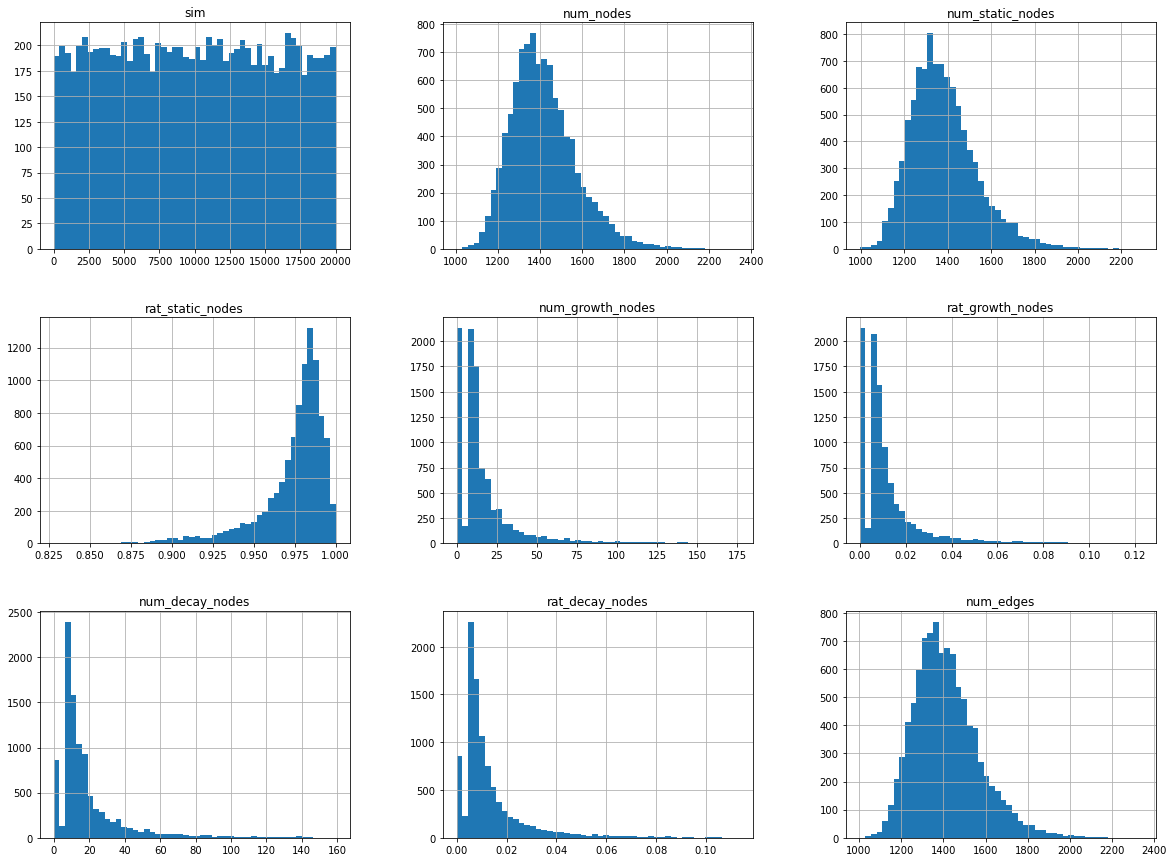

In [31]:
tree_dist_df.hist(bins=50,figsize=(20,15))

### Split the train/test sets

In [32]:
random_seed = 123
np.random.seed(random_seed)
split_folder = f'../data/preprocessed_data/split_rs{random_seed}'
os.makedirs(split_folder, exist_ok=True)

from sklearn.model_selection import  train_test_split
#split the data for training and testing
train_ids, test_ids = train_test_split(tree_ids, test_size=0.2)
print(f"Train: {len(train_ids)}, Test: {len(test_ids)}")
print(test_ids[:10])

Train: 7748, Test: 1937
[18905 13921 15041  2500  4130  6861  8934  5555  6858  8026]


In [33]:
train_edge_df = edge_df[edge_df['sim'].isin(train_ids)]
test_edge_df = edge_df[edge_df['sim'].isin(test_ids)]

print(f'Train edges: {train_edge_df.shape[0]}')
print(f'Test edges: {test_edge_df.shape[0]}')

Train edges: 10973761
Test edges: 2737563


### Normalize the edge weights

array([[<AxesSubplot:title={'center':'weight1'}>,
        <AxesSubplot:title={'center':'weight2'}>]], dtype=object)

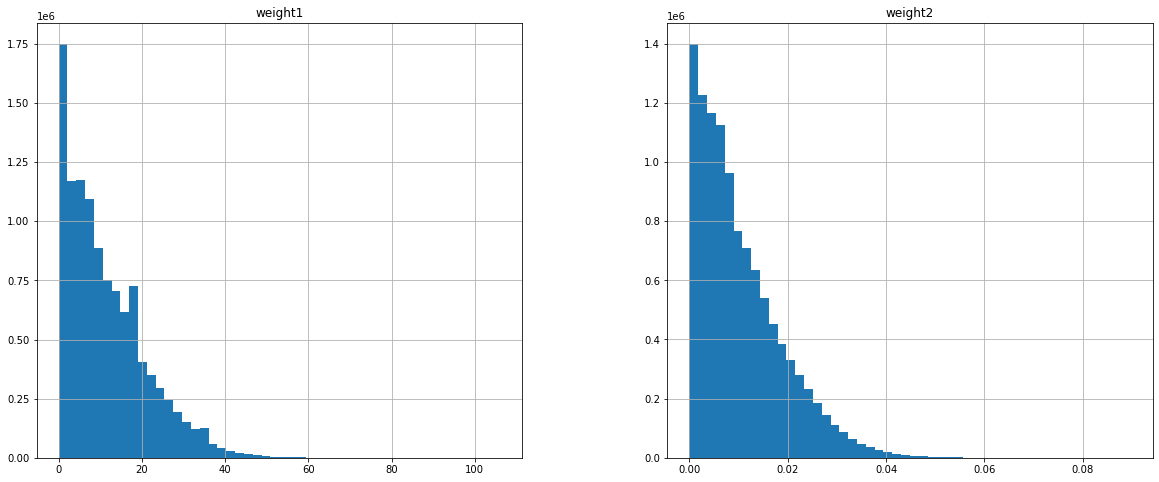

In [34]:
train_edge_df[aly_edge_feat_cols].hist(bins=50,figsize=(20,8))

D:\Downloads\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


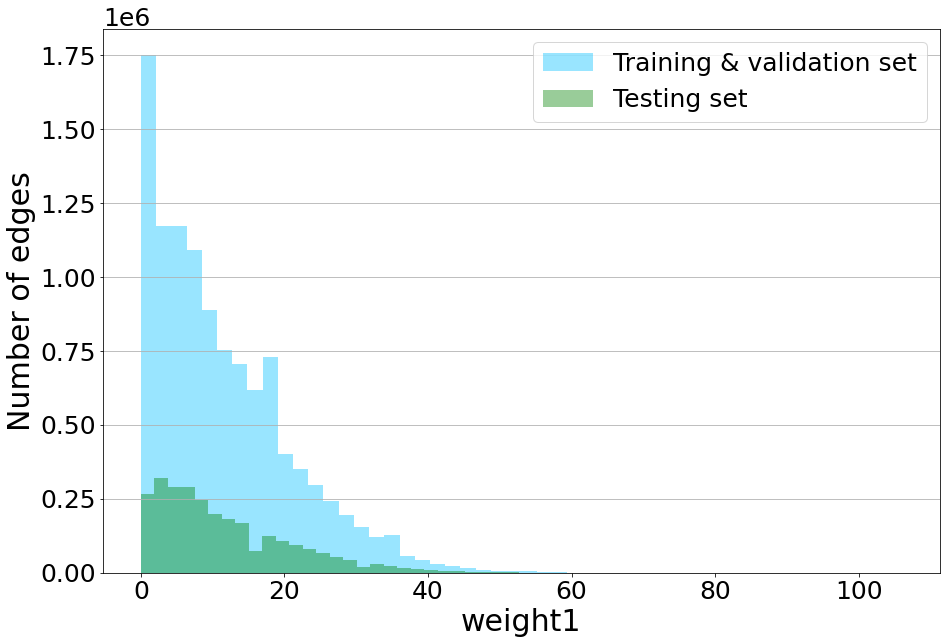

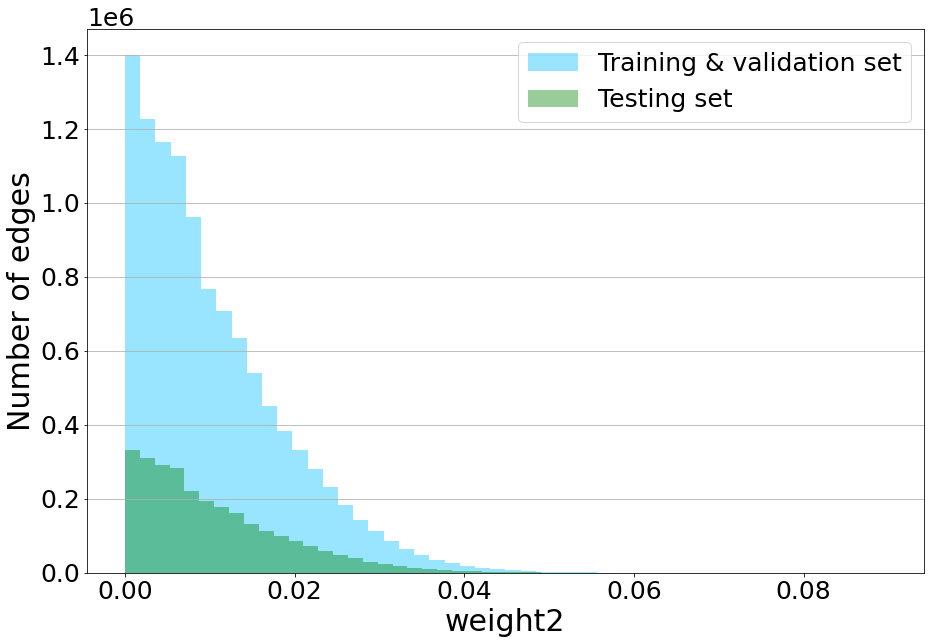

In [35]:
#generate figure plots
for feat in aly_edge_feat_cols:
    fig = plt.figure(figsize=[15,10])
    plt.rcParams.update({'font.size': 25})
    ax1 = fig.add_subplot(111)
    #ax2 = ax1.twinx()
    sns.distplot(train_edge_df[feat],hist=True,kde=False,rug=False,color='#00BFFF',label='Train & Validation Set',ax=ax1)
    sns.distplot(test_edge_df[feat],hist=True,kde=False,rug=False,color='green',label='Test Set',ax=ax1)
    #ax2.set(ylim=(0,1.1))
    ax1.axes.set_ylabel("Number of edges",fontsize=30)
    ax1.axes.set_xlabel(f"{feat}",fontsize=30)
    plt.grid(axis = "y")
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax1.legend(['Training & validation set','Testing set'],fontsize=25,loc=1)
    #fig.savefig(f"../paper/edge_dist/{feat}.svg",dpi=600,format='svg')

In [36]:
train_edge_df['weight1'].describe()

count    1.097376e+07
mean     1.158858e+01
std      9.448234e+00
min      0.000000e+00
25%      4.000000e+00
50%      9.000000e+00
75%      1.700000e+01
max      1.060000e+02
Name: weight1, dtype: float64

In [37]:
train_edge_df.loc[:, 'weight1_arsinh'] = np.arcsinh(train_edge_df['weight1'])

In [38]:
train_edge_df['weight2'].describe()

count    1.097376e+07
mean     1.043007e-02
std      8.547599e-03
min      0.000000e+00
25%      3.751486e-03
50%      8.193434e-03
75%      1.508991e-02
max      8.970773e-02
Name: weight2, dtype: float64

In [39]:
train_edge_df.loc[:, 'weight2_arsinh'] = np.arcsinh(train_edge_df['weight2'])

array([[<AxesSubplot:title={'center':'weight1'}>,
        <AxesSubplot:title={'center':'weight2'}>],
       [<AxesSubplot:title={'center':'weight1_arsinh'}>,
        <AxesSubplot:title={'center':'weight2_arsinh'}>]], dtype=object)

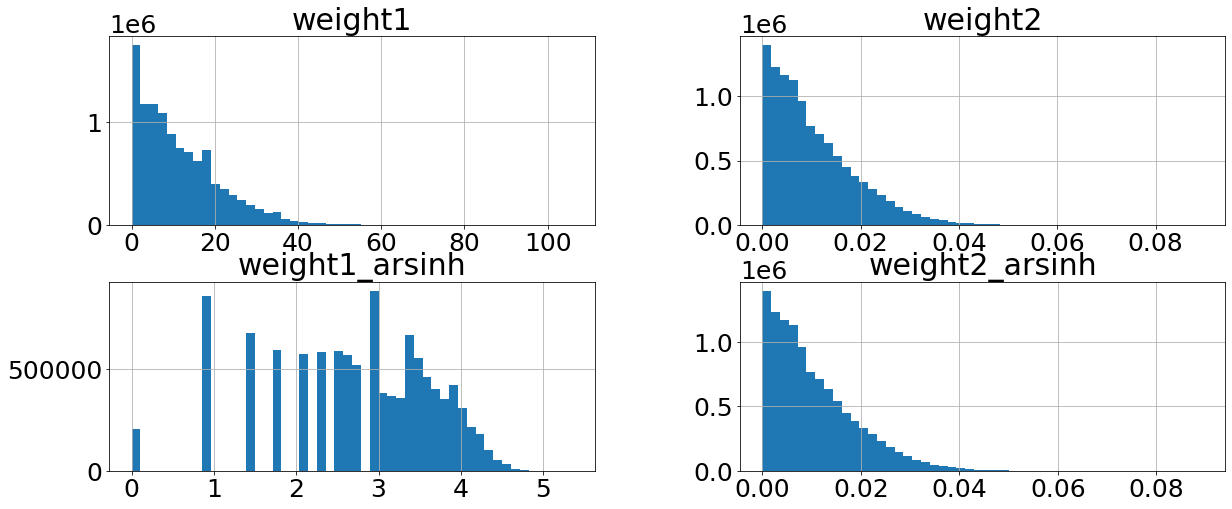

In [40]:
aly_edge_feat_cols += ['weight1_arsinh', 'weight2_arsinh']

train_edge_df[aly_edge_feat_cols].hist(bins=50,figsize=(20,8))

In [41]:
from sklearn import preprocessing

# Standardization edge features
std_scaler = preprocessing.StandardScaler().fit(train_edge_df[aly_edge_feat_cols])
norm_num_feat_cols = [f'{col_name}-norm' for col_name in aly_edge_feat_cols]

norm_train_vals = std_scaler.transform(train_edge_df[aly_edge_feat_cols])
norm_train_edge_df = pd.DataFrame(norm_train_vals, columns=norm_num_feat_cols, index=train_edge_df.index)
train_edge_df = pd.concat([train_edge_df, norm_train_edge_df], axis=1)

In [42]:
train_edge_df

,from,to,weight1,weight2,sim,weight1_arsinh,weight2_arsinh,weight1-norm,weight2-norm,weight1_arsinh-norm,weight2_arsinh-norm
0,651,652,5,0.004204,10000,2.312438,0.004204,-0.697335,-0.728425,-0.433586,-0.728462
1,652,653,1,0.000820,10000,0.881374,0.000820,-1.120694,-1.124340,-1.859741,-1.124440
2,653,654,3,0.002780,10000,1.818446,0.002780,-0.909015,-0.894972,-0.925883,-0.895036
3,654,1,5,0.004050,10000,2.312438,0.004050,-0.697335,-0.746376,-0.433586,-0.746416
4,654,655,3,0.002427,10000,1.818446,0.002427,-0.909015,-0.936319,-0.925883,-0.936389
...,...,...,...,...,...,...,...,...,...,...,...
13712608,1396,231,12,0.009602,999,3.179785,0.009602,0.043544,-0.096912,0.430785,-0.096864
13712609,1396,575,12,0.009680,999,3.179785,0.009680,0.043544,-0.087716,0.430785,-0.087667
13712610,1393,1397,3,0.002858,999,1.818446,0.002858,-0.909015,-0.885919,-0.925883,-0.885981
13712611,1397,42,1,0.000948,999,0.881374,0.000948,-1.120694,-1.109314,-1.859741,-1.109411


In [43]:
print(std_scaler.mean_, std_scaler.scale_)

[1.15885816e+01 1.04300693e-02 2.74751711e+00 1.04293769e-02] [9.44823388e+00 8.54759853e-03 1.00344247e+00 8.54622575e-03]


In [44]:
# Update the feat_dict.json
import json

js_f = osp.join('./feat_dict.json')

with open(js_f, 'r') as infile:
    feat_dict = json.load(infile)

feat_dict['raw_edge_feats'] = aly_edge_feat_cols
feat_dict['norm_edge_feats'] = [f'{org_feat_col}-norm' for org_feat_col in aly_edge_feat_cols]
feat_dict['norm_edge_feats_arsinh'] = [f'{feat_col}-norm' for feat_col in aly_edge_feat_cols[2:]]

node_feat_cols = feat_dict['norm_onehot_feats']
raw_edge_feat_cols = feat_dict['raw_edge_feats']
norm_edge_feat_cols = feat_dict['norm_edge_feats']

print(f'Inputs: {len(node_feat_cols)}, {node_feat_cols}')
label_feat_col = 'dynamic_cat'

with open(js_f, 'w') as outfile:
    json.dump(feat_dict, outfile, sort_keys=True, indent=4)

Inputs: 16, ['oster-norm', 'PD-norm', 'abs_growth_rate-norm', 'fraction_time_growth-norm', 'r_max-norm', 'cherries-norm', 'BLD-norm', 'new_R0-norm', 'ltt_shape_cat_0', 'ltt_shape_cat_1', 'ltt_shape_cat_2', 'ltt_shape_cat_3', 'gamma_cat_0', 'gamma_cat_1', 'gamma_cat_2', 'gamma_cat_3']


In [45]:
test_edge_df.loc[:, 'weight1_arsinh'] = np.arcsinh(test_edge_df['weight1'])
test_edge_df.loc[:, 'weight2_arsinh'] = np.arcsinh(test_edge_df['weight2'])
test_edge_df

,from,to,weight1,weight2,sim,weight1_arsinh,weight2_arsinh
3892,748,1,2,0.001943,10004,1.443635,0.001943
3893,748,749,4,0.003538,10004,2.094713,0.003538
3894,749,750,2,0.001968,10004,1.443635,0.001968
3895,750,751,6,0.005759,10004,2.491780,0.005758
3896,751,752,9,0.008228,10004,2.893444,0.008228
...,...,...,...,...,...,...,...
13699840,1167,35,4,0.003640,9981,2.094713,0.003640
13699841,1167,89,14,0.013862,9981,3.333478,0.013862
13699842,1164,1168,6,0.005729,9981,2.491780,0.005729
13699843,1168,58,18,0.017806,9981,3.584290,0.017805


In [46]:
norm_test_vals = std_scaler.transform(test_edge_df[raw_edge_feat_cols])
norm_test_edge_df = pd.DataFrame(norm_test_vals, columns=norm_edge_feat_cols, index=test_edge_df.index)
test_edge_df = pd.concat([test_edge_df, norm_test_edge_df], axis=1)

In [47]:
test_edge_df.head()

,from,to,weight1,weight2,sim,weight1_arsinh,weight2_arsinh,weight1-norm,weight2-norm,weight1_arsinh-norm,weight2_arsinh-norm
3892,748,1,2,0.001943,10004,1.443635,0.001943,-1.014854,-0.992965,-1.299408,-0.993043
3893,748,749,4,0.003538,10004,2.094713,0.003538,-0.803175,-0.806289,-0.650565,-0.806339
3894,749,750,2,0.001968,10004,1.443635,0.001968,-1.014854,-0.989987,-1.299408,-0.990065
3895,750,751,6,0.005759,10004,2.491780,0.005758,-0.591495,-0.546534,-0.254860,-0.546545
3896,751,752,9,0.008228,10004,2.893444,0.008228,-0.273975,-0.257625,0.145426,-0.257597


array([[<AxesSubplot:title={'center':'weight1-norm'}>,
        <AxesSubplot:title={'center':'weight2-norm'}>],
       [<AxesSubplot:title={'center':'weight1_arsinh-norm'}>,
        <AxesSubplot:title={'center':'weight2_arsinh-norm'}>]],
      dtype=object)

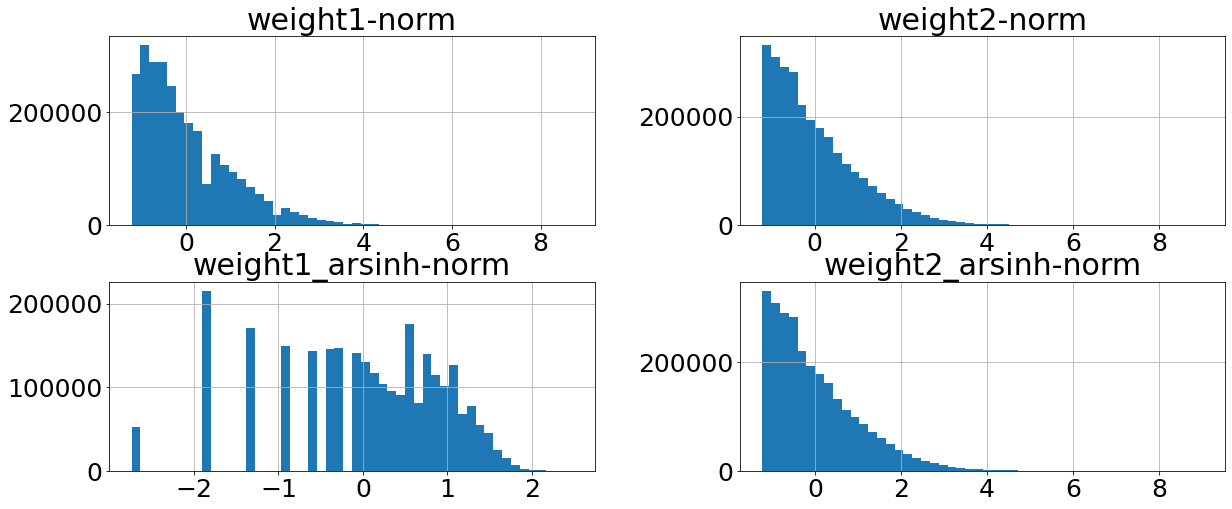

In [48]:
test_edge_df[norm_edge_feat_cols].hist(bins=50,figsize=(20,8))

D:\Downloads\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


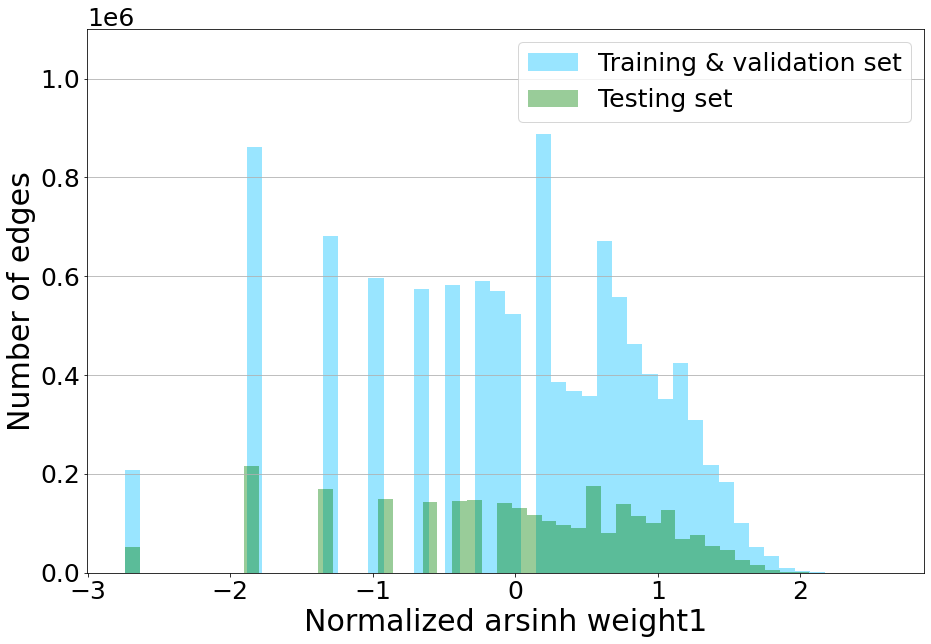

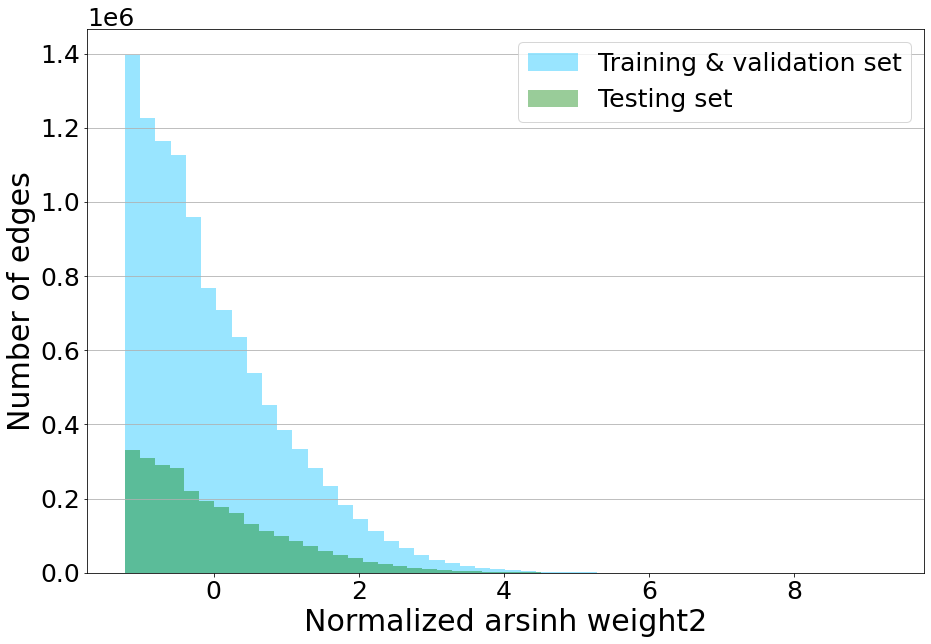

In [49]:
i=1
for feat in norm_edge_feat_cols[2:]:
    fig = plt.figure(figsize=[15,10])
    plt.rcParams.update({'font.size': 25})
    ax1 = fig.add_subplot(111)
    #ax2 = ax1.twinx()
    sns.distplot(train_edge_df[feat],hist=True,kde=False,rug=False,color='#00BFFF',label='Train & Validation Set',ax=ax1)
    sns.distplot(test_edge_df[feat],hist=True,kde=False,rug=False,color='green',label='Test Set',ax=ax1)
    if i == 1:
        ax1.set(ylim=(0,1100000))
        i=0
    ax1.axes.set_ylabel("Number of edges",fontsize=30)
    ax1.axes.set_xlabel(f"Normalized arsinh {feat[0:7]}",fontsize=30)
    plt.grid(axis = "y")
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax1.legend(['Training & validation set','Testing set'],fontsize=25,loc=1)
    #fig.savefig(f"../paper/edge_dist/{feat}.svg",dpi=600,format='svg')

In [50]:
train_ids, valid_ids = train_test_split(train_ids, test_size=0.25)
print(f"Train: {len(train_ids)}, Valid: {len(valid_ids)}")
print(valid_ids[:10])

Train: 5811, Valid: 1937
[ 5766 18451   638 18095  9284  2699  3806 10162 16601 13857]


In [51]:
train_full_df = train_edge_df[train_edge_df['sim'].isin(train_ids)]
valid_full_df = train_edge_df[train_edge_df['sim'].isin(valid_ids)]

print(f'Train edge: {train_full_df.shape[0]}')
print(f'Valid edge: {valid_full_df.shape[0]}')
train_full_df.head()

Train edge: 8222962
Valid edge: 2750799


,from,to,weight1,weight2,sim,weight1_arsinh,weight2_arsinh,weight1-norm,weight2-norm,weight1_arsinh-norm,weight2_arsinh-norm
0,651,652,5,0.004204,10000,2.312438,0.004204,-0.697335,-0.728425,-0.433586,-0.728462
1,652,653,1,0.000820,10000,0.881374,0.000820,-1.120694,-1.124340,-1.859741,-1.124440
2,653,654,3,0.002780,10000,1.818446,0.002780,-0.909015,-0.894972,-0.925883,-0.895036
3,654,1,5,0.004050,10000,2.312438,0.004050,-0.697335,-0.746376,-0.433586,-0.746416
4,654,655,3,0.002427,10000,1.818446,0.002427,-0.909015,-0.936319,-0.925883,-0.936389


In [52]:
# Save the train/test to the disk

train_full_df.to_csv(f'{split_folder}/train_edge.csv', index=False)
valid_full_df.to_csv(f'{split_folder}/valid_edge.csv', index=False)
test_edge_df.to_csv(f'{split_folder}/test_edge.csv', index=False)

### Tree distribution for train & test sets

In [53]:
from collections import defaultdict
train_dist = defaultdict(list)
for tree_id in train_ids:
    train_dist['sim'].append(tree_id)
    onetree_node_df = node_df[node_df['sim'] == tree_id] 
    num_nodes = onetree_node_df.shape[0]
    train_dist['num_nodes'].append(num_nodes)
    
    #num_background_nodes = onetree_node_df[onetree_node_df['cluster_id']=='Background'].shape[0]
    #tree_dist_dict['num_background_nodes'].append(num_background_nodes)
    #tree_dist_dict[f'rat_background_nodes'].append(num_background_nodes / num_nodes)
    
    for label in ['static', 'growth', 'decay']:
        num_label_nodes = onetree_node_df[onetree_node_df['dynamic']==label].shape[0]
        train_dist[f'num_{label}_nodes'].append(num_label_nodes)
        train_dist[f'ratio_{label}_nodes'].append(num_label_nodes / num_nodes)
        
    onetree_edge_df = edge_df[edge_df['sim'] == tree_id]
    # print(onetree_edge_df.shape)
    train_dist['num_edges'].append(onetree_edge_df.shape[0])
    
train_dist_df = pd.DataFrame.from_dict(train_dist)

array([[<AxesSubplot:title={'center':'sim'}>,
        <AxesSubplot:title={'center':'num_nodes'}>,
        <AxesSubplot:title={'center':'num_static_nodes'}>],
       [<AxesSubplot:title={'center':'ratio_static_nodes'}>,
        <AxesSubplot:title={'center':'num_growth_nodes'}>,
        <AxesSubplot:title={'center':'ratio_growth_nodes'}>],
       [<AxesSubplot:title={'center':'num_decay_nodes'}>,
        <AxesSubplot:title={'center':'ratio_decay_nodes'}>,
        <AxesSubplot:title={'center':'num_edges'}>]], dtype=object)

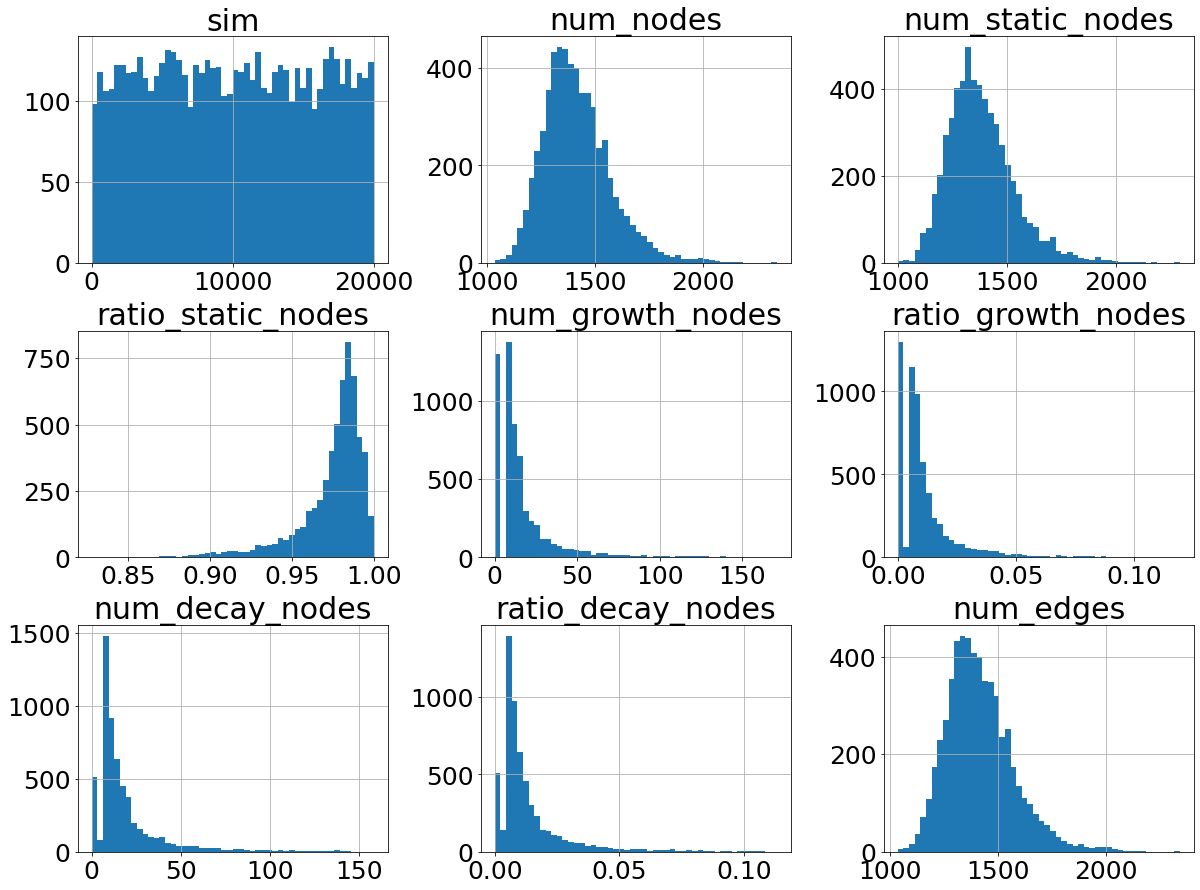

In [54]:
train_dist_df.hist(bins=50,figsize=(20,15))

In [55]:
train_dist_df

,sim,num_nodes,num_static_nodes,ratio_static_nodes,num_growth_nodes,ratio_growth_nodes,num_decay_nodes,ratio_decay_nodes,num_edges
0,6261,1363,1313,0.963316,35,0.025679,15,0.011005,1362
1,428,1629,1578,0.968692,43,0.026397,8,0.004911,1628
2,13801,1399,1333,0.952823,11,0.007863,55,0.039314,1398
3,2539,1338,1318,0.985052,12,0.008969,8,0.005979,1337
4,9026,1370,1296,0.945985,11,0.008029,63,0.045985,1369
...,...,...,...,...,...,...,...,...,...
5806,7514,1429,1399,0.979006,20,0.013996,10,0.006998,1428
5807,10841,1269,1239,0.976359,21,0.016548,9,0.007092,1268
5808,4601,1674,1650,0.985663,9,0.005376,15,0.008961,1673
5809,5797,1539,1446,0.939571,82,0.053281,11,0.007147,1538


In [56]:
from collections import defaultdict
test_dist = defaultdict(list)
for tree_id in test_ids:
    test_dist['sim'].append(tree_id)
    onetree_node_df = node_df[node_df['sim'] == tree_id] 
    num_nodes = onetree_node_df.shape[0]
    test_dist['num_nodes'].append(num_nodes)
    
    #num_background_nodes = onetree_node_df[onetree_node_df['cluster_id']=='Background'].shape[0]
    #tree_dist_dict['num_background_nodes'].append(num_background_nodes)
    #tree_dist_dict[f'rat_background_nodes'].append(num_background_nodes / num_nodes)
    
    for label in ['static', 'growth', 'decay']:
        num_label_nodes = onetree_node_df[onetree_node_df['dynamic']==label].shape[0]
        test_dist[f'num_{label}_nodes'].append(num_label_nodes)
        test_dist[f'ratio_{label}_nodes'].append(num_label_nodes / num_nodes)
        
    onetree_edge_df = edge_df[edge_df['sim'] == tree_id]
    # print(onetree_edge_df.shape)
    test_dist['num_edges'].append(onetree_edge_df.shape[0])
    
test_dist_df = pd.DataFrame.from_dict(test_dist)

array([[<AxesSubplot:title={'center':'sim'}>,
        <AxesSubplot:title={'center':'num_nodes'}>,
        <AxesSubplot:title={'center':'num_static_nodes'}>],
       [<AxesSubplot:title={'center':'ratio_static_nodes'}>,
        <AxesSubplot:title={'center':'num_growth_nodes'}>,
        <AxesSubplot:title={'center':'ratio_growth_nodes'}>],
       [<AxesSubplot:title={'center':'num_decay_nodes'}>,
        <AxesSubplot:title={'center':'ratio_decay_nodes'}>,
        <AxesSubplot:title={'center':'num_edges'}>]], dtype=object)

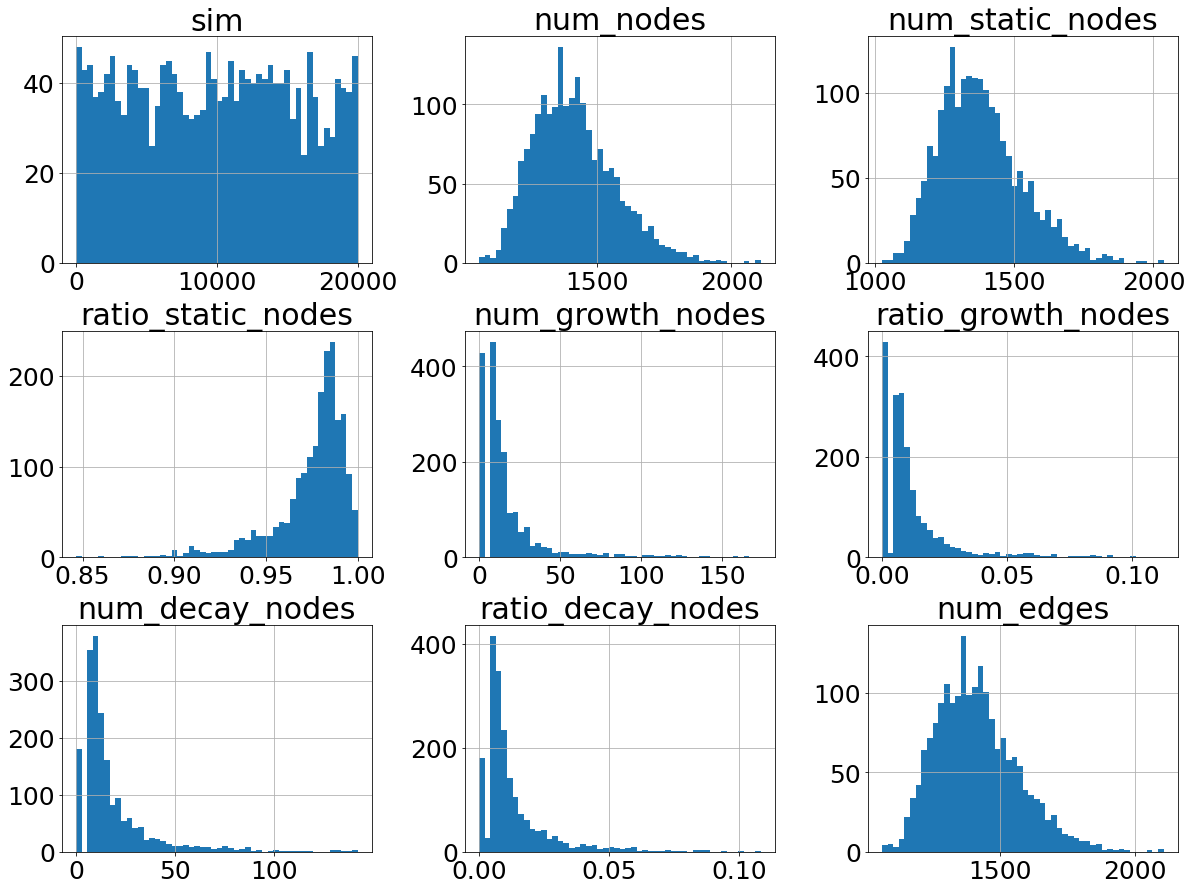

In [57]:
test_dist_df.hist(bins=50,figsize=(20,15))

In [58]:
test_dist_df.columns.values[1:]

array(['num_nodes', 'num_static_nodes', 'ratio_static_nodes',
       'num_growth_nodes', 'ratio_growth_nodes', 'num_decay_nodes',
       'ratio_decay_nodes', 'num_edges'], dtype=object)

D:\Downloads\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


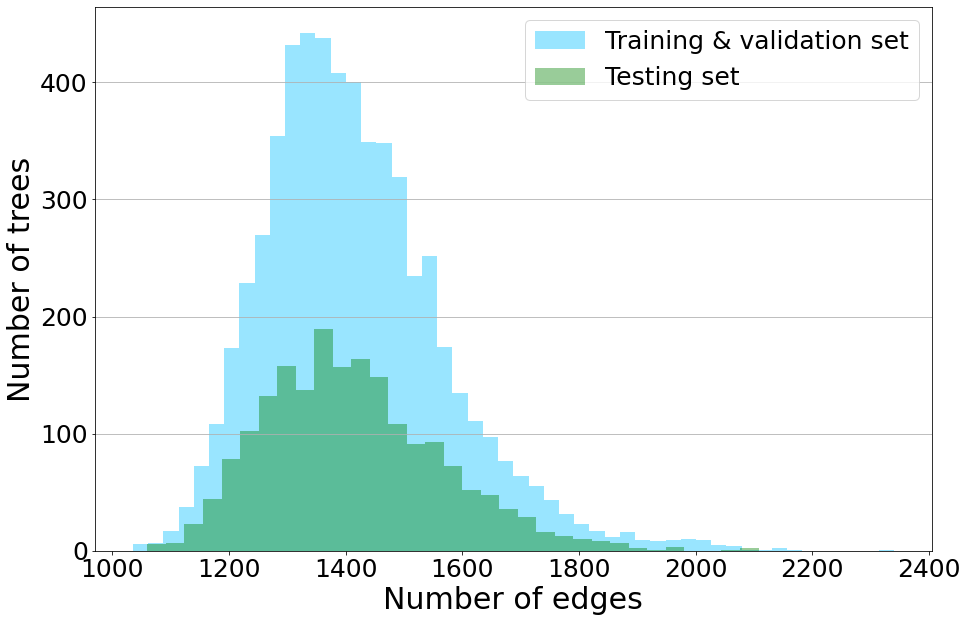

In [59]:
i = 7
feat = test_dist_df.columns.values[1:][i]
fig = plt.figure(figsize=[15,10])
plt.rcParams.update({'font.size': 25})
ax1 = fig.add_subplot(111)
#ax2 = ax1.twinx()
sns.distplot(train_dist_df[feat],hist=True,kde=False,rug=False,color='#00BFFF',label='Train & Validation Set',ax=ax1)
sns.distplot(test_dist_df[feat],hist=True,kde=False,rug=False,color='green',label='Test Set',ax=ax1)
#ax1.set(ylim=(0,1000))
ax1.axes.set_ylabel("Number of trees",fontsize=30)
ax1.axes.set_xlabel("Number of edges",fontsize=30)
plt.grid(axis = "y")
ax1.legend(['Training & validation set','Testing set'],fontsize=25,loc=1)
#fig.savefig(f"../paper/tree_feat/{feat}.svg",dpi=600,format='svg')

### Build a tree with DGL

In [54]:
import networkx as nx
import matplotlib.pyplot as plt

In [57]:
# Load a tree from the train data
train_node_df = pd.read_csv(f'{split_folder}/train.csv')
vis_tree_id = train_ids[0]
print(vis_tree_id)

6261


In [58]:
onetree_node_df = train_node_df[train_node_df['sim'] == vis_tree_id] 
onetree_edge_df = train_edge_df[edge_df['sim'] == vis_tree_id]

<ipython-input-58-44110b4dfc21>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  onetree_edge_df = train_edge_df[edge_df['sim'] == vis_tree_id]


In [59]:
onetree_node_df.head()

,sim,cluster_id,state,dynamic,dynamic_model,sampling_fraction,cluster_size,timespan,gamma,oster,...,cluster_size-norm,timespan-norm,oster-norm,PD-norm,abs_growth_rate-norm,fraction_time_growth-norm,r_max-norm,cherries-norm,BLD-norm,R0-norm
906020,6261,c1,A,static,0.0,0.466541,89.0,44.0,0.013943,55.007245,...,0.335964,1.514178,2.130277,0.98041,-0.004706,-0.615829,0.025622,-0.552205,0.764355,2.239296e-15
906021,6261,c1,A,static,0.0,0.466541,89.0,44.0,0.013943,55.007245,...,0.335964,1.514178,2.130277,0.98041,-0.004706,-0.615829,0.025622,-0.552205,0.764355,2.239296e-15
906022,6261,c1,A,static,0.0,0.466541,89.0,44.0,0.013943,55.007245,...,0.335964,1.514178,2.130277,0.98041,-0.004706,-0.615829,0.025622,-0.552205,0.764355,2.239296e-15
906023,6261,c1,A,static,0.0,0.466541,89.0,44.0,0.013943,55.007245,...,0.335964,1.514178,2.130277,0.98041,-0.004706,-0.615829,0.025622,-0.552205,0.764355,2.239296e-15
906024,6261,c1,A,static,0.0,0.466541,89.0,44.0,0.013943,55.007245,...,0.335964,1.514178,2.130277,0.98041,-0.004706,-0.615829,0.025622,-0.552205,0.764355,2.239296e-15


In [60]:
onetree_edge_df

,from,to,weight1,weight2,sim,weight1_arsinh,weight2_arsinh,weight1-norm,weight2-norm,weight1_arsinh-norm,weight2_arsinh-norm
10859379,707,708,4,0.003203,6261,2.094713,0.003203,-0.803175,-0.845452,-0.650565,-0.845507
10859380,708,709,7,0.006256,6261,2.644121,0.006256,-0.485655,-0.488320,-0.103042,-0.488322
10859381,709,710,2,0.001843,6261,1.443635,0.001843,-1.014854,-1.004644,-1.299408,-1.004725
10859382,710,711,1,0.000951,6261,0.881374,0.000951,-1.120694,-1.108946,-1.859741,-1.109043
10859383,711,712,25,0.022375,6261,3.912423,0.022373,1.419463,1.397447,1.160909,1.397534
...,...,...,...,...,...,...,...,...,...,...,...
10860736,1362,98,2,0.001736,6261,1.443635,0.001736,-1.014854,-1.017169,-1.299408,-1.017252
10860737,1362,674,8,0.007023,6261,2.776472,0.007023,-0.379815,-0.398585,0.028856,-0.398575
10860738,1358,1363,14,0.012412,6261,3.333478,0.012412,0.255224,0.231860,0.583950,0.231941
10860739,1363,387,10,0.008616,6261,2.998223,0.008616,-0.168135,-0.212208,0.249846,-0.212173


In [61]:
import dgl
import networkx as nx
import torch
import pygraphviz as pgv

Using backend: pytorch


In [62]:
src_ids = torch.tensor(onetree_edge_df['from'].values)
dst_ids = torch.tensor(onetree_edge_df['to'].values)

# Note: the start idx of the node is 0 not 1. But simulation node starts with 1
# We need substract 1 to the node idx for edges and nodes files.
src_ids -= 1
dst_ids -= 1

In [63]:
g = dgl.graph((src_ids, dst_ids))
nx_g = dgl.to_networkx(g)

print(f'Nodes: {g.number_of_nodes()}')
print(f'Edges: {g.number_of_edges()}')

Nodes: 1363
Edges: 1362


In [64]:
g.nodes()

tensor([   0,    1,    2,  ..., 1360, 1361, 1362])

### Assign features to nodes

In [65]:
sorted_onetree_node_df = onetree_node_df.sort_values(by='node')
print(sorted_onetree_node_df['node'].values)
n_nodes = sorted_onetree_node_df.shape[0]
sorted_onetree_node_df.tail()

[1.000e+00 2.000e+00 3.000e+00 ... 1.361e+03 1.362e+03 1.363e+03]


,sim,cluster_id,state,dynamic,dynamic_model,sampling_fraction,cluster_size,timespan,gamma,oster,...,cluster_size-norm,timespan-norm,oster-norm,PD-norm,abs_growth_rate-norm,fraction_time_growth-norm,r_max-norm,cherries-norm,BLD-norm,R0-norm
6767398,6261,Background,Background,bg,0.0,0.057488,618.0,98.0,-17.126464,98.003347,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6767393,6261,Background,Background,bg,0.0,0.057488,618.0,98.0,-17.126464,98.003347,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6767392,6261,Background,Background,bg,0.0,0.057488,618.0,98.0,-17.126464,98.003347,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6767383,6261,Background,Background,bg,0.0,0.057488,618.0,98.0,-17.126464,98.003347,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6767360,6261,Background,Background,bg,0.0,0.057488,618.0,98.0,-17.126464,98.003347,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:>

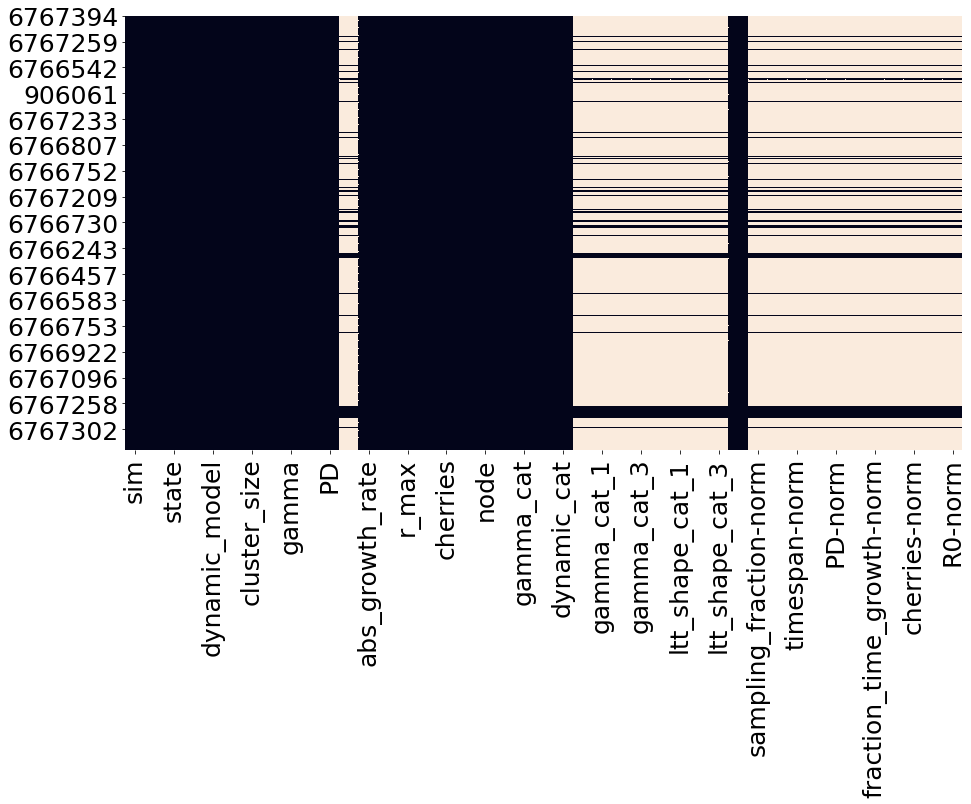

In [66]:
# Now using heatmaps
plt.figure(figsize=(15,8))
sns.heatmap(sorted_onetree_node_df.isnull(), cbar=False)

<AxesSubplot:>

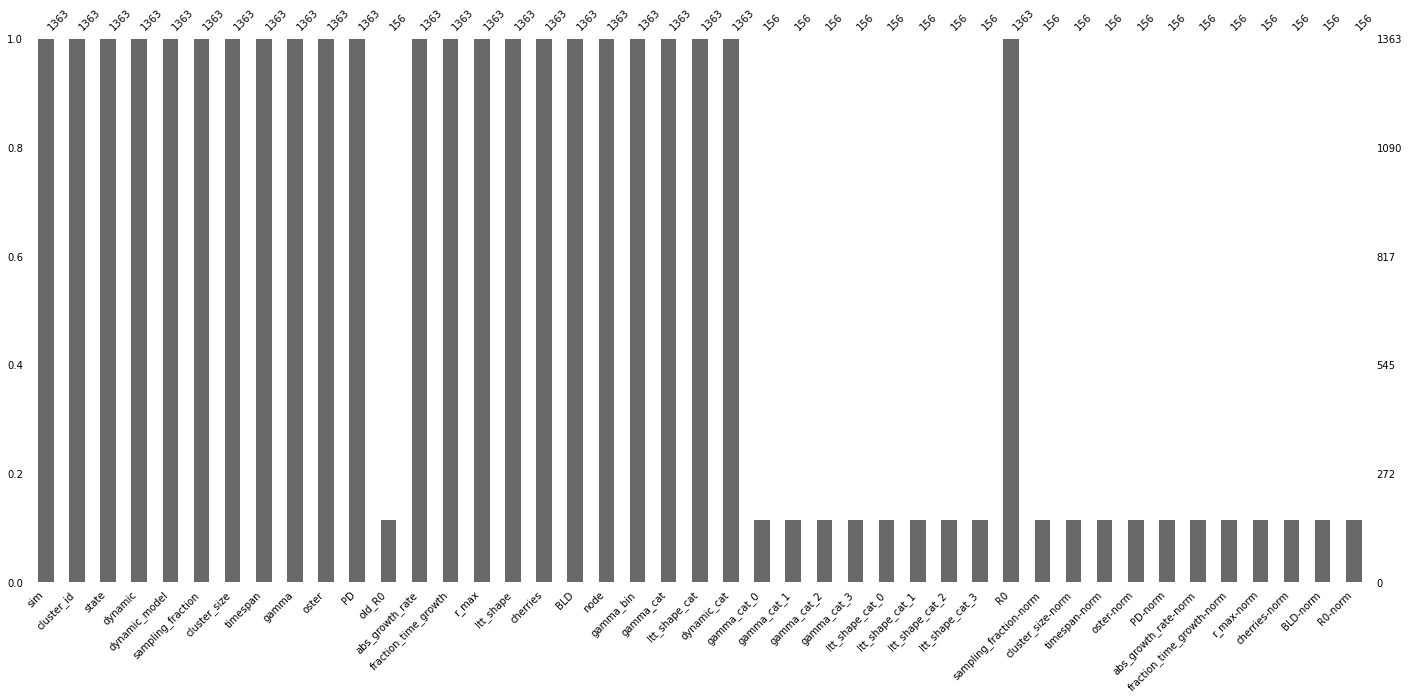

In [67]:
# Next is to use the missingno library to analyze the missing values
import missingno as msno 

msno.bar(sorted_onetree_node_df,labels=True,fontsize=10) 

In [68]:
g.ndata['feat'] = torch.tensor(sorted_onetree_node_df[node_feat_cols].values)
g.ndata['label'] = torch.tensor(sorted_onetree_node_df[label_feat_col].values)

for i in range(n_nodes):
    if not torch.all(torch.isnan(g.ndata['feat'][i])):
        print(f"NodeID: {i+1}, {g.ndata['feat'][i]}, {g.ndata['label'][i]}")
        break

NodeID: 38, tensor([ 2.1303e+00,  9.8041e-01, -4.7063e-03, -6.1583e-01,  2.5622e-02,
        -5.5221e-01,  7.6436e-01,  2.2393e-15,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00], dtype=torch.float64), 0


### Assign features to edges

In [69]:
g.edges()

(tensor([ 706,  707,  708,  ..., 1357, 1362, 1362]),
 tensor([ 707,  708,  709,  ..., 1362,  386,  660]))

In [70]:
# The edge features are assigned to the edata according to the edge order, not considerring the src and dst
g.edata['feat'] = torch.tensor(onetree_edge_df[norm_edge_feat_cols].values)
g.edata['feat'][0]

tensor([-0.8032, -0.8455, -0.6506, -0.8455], dtype=torch.float64)

defaultdict(<function <lambda> at 0x7fb6e8cb5048>, {2: 1294, 0: 12, 1: 9})


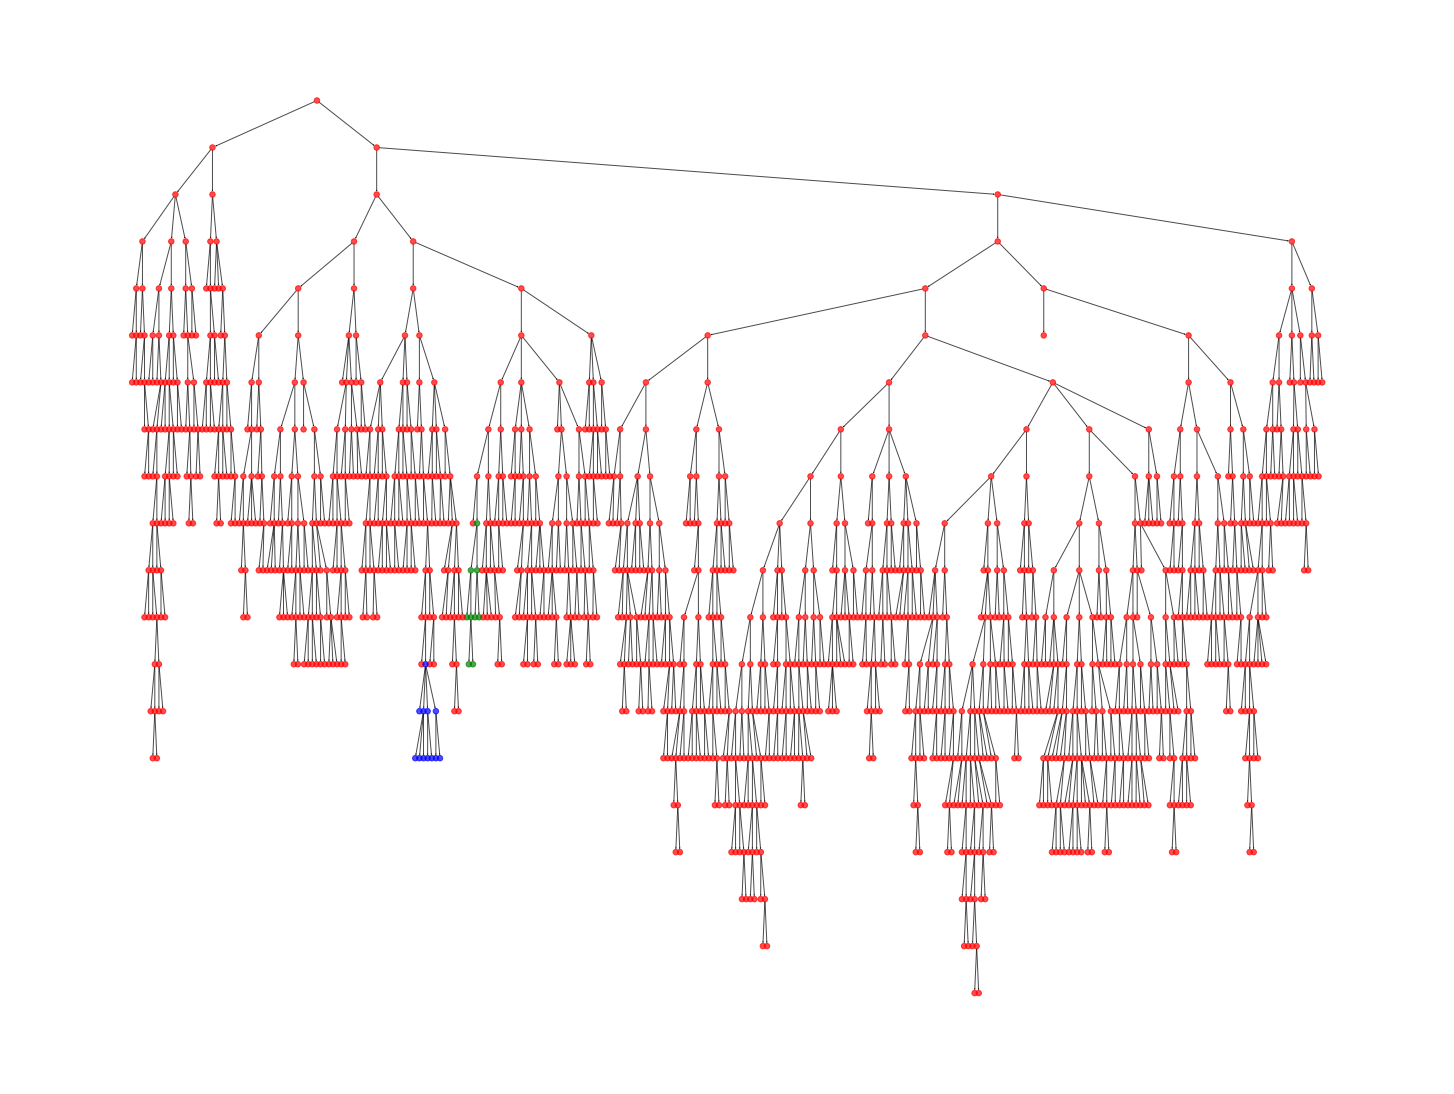

In [49]:
plt.figure(figsize=(20, 15))
color_map = []
node_labels = g.ndata['label'].numpy()
label_counter = defaultdict(lambda: 0)

for node_id in nx_g:
    node_label = node_labels[node_id]
    if np.isnan(node_label):
        label_counter['bg'] += 1
        color_map.append('gray')
    else:
        if node_label == 0:  # decay
            color_map.append('blue')
        elif node_label == 1:   # growth
            color_map.append('green')
        elif node_label == 2:   # static
            color_map.append('red')
        label_counter[node_label] += 1
            
print(label_counter)
pos = nx.nx_agraph.graphviz_layout(nx_g, prog='dot')
nx.draw(nx_g, pos, with_labels=False, node_size=30, node_color=color_map, alpha=.7, arrowsize=1)